In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

env_1_sale_args['number_of_flips'] = 5

In [4]:
num_users = 5000
# # Random policy as logging policy
# data_random = deepcopy(env).generate_logs(num_users)
# data = data_random.copy()
# pkl.dump(data,open(str('data\data'+str(num_users)+'rand.pkl'),'wb'))

data_random = pkl.load(open(str('data\data'+str(num_users)+'rand.pkl'),'rb'))
data = data_random.copy()

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [02:46<00:00, 29.96it/s]


## Reward shaping

#### Previous version : reward = click

In [5]:
from recogym.agents.sale_agent import ClickRewardProvider

Click_rewards = ClickRewardProvider()

#### V0 attribute the reward of the MDP

In [6]:
from recogym.agents.sale_agent import MDPRewardProvider

MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
MDP_rewards_all_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)

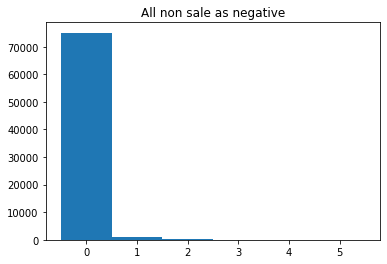

Share of sales that are taken into account in the trainset :  0.8315123634272571
Number of sales in the trainset : 1446.0


In [5]:
MDP_rewards_all.observe(data)
MDP_base_all = MDP_rewards_all.features()
# display(MDP_base_all)
# len(MDP_base_all)

trainset = MDP_base_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))
print("Number of sales in the trainset :",np.sum(trainset["y"]))

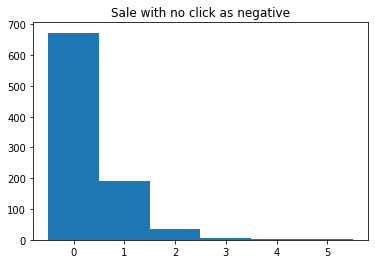

Share of sales that are taken into account in the trainset :  0.16503737780333524
Number of sales in the trainset : 287.0


In [6]:
MDP_rewards.observe(data)
MDP_base = MDP_rewards.features()
# display(MDP_base)
# print(len(MDP_base))

trainset = MDP_base

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))
print("Number of sales in the trainset :",np.sum(trainset["y"]))

 #### V1 : Only attribute reward if the recommended product is sold before the next clicked recommendation

In [7]:
from recogym.agents.sale_agent import ShortTermRewardProvider
st_rewards = ShortTermRewardProvider()
st_rewards_all = ShortTermRewardProvider(clicks_only=False)

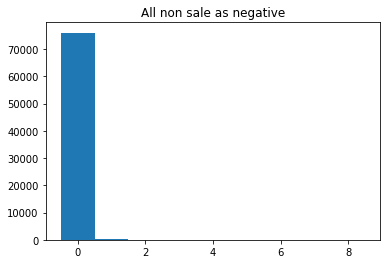

Share of sales that are taken into account in the trainset :  0.18171362852213915


In [8]:
st_rewards_all.observe(data)
st_all = st_rewards_all.features()

trainset = st_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))

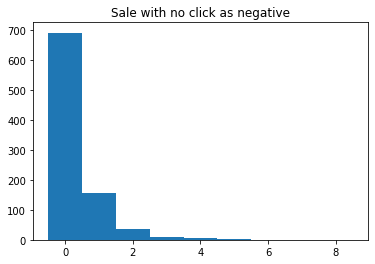

Share of sales that are taken into account in the trainset :  0.18171362852213915


In [9]:
st_rewards.observe(data)
st = st_rewards.features()
# st.to_csv("data/data_clicked.csv")

trainset = st

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))

#### V2 : Attribute a reward if the product was sold later at one point during the user session

In case of several recommendations for the same product, attribute it to the last time it was recommended.
Thus, for each user : look at every sale, find the last time it was recommended (if any), and give reward

In [10]:
from recogym.agents.sale_agent import CumulativeRewardProvider
cum_rewards = CumulativeRewardProvider()
cum_rewards_all = CumulativeRewardProvider(clicks_only=False)

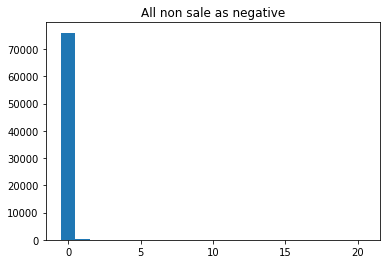

Share of sales that are taken into account in the trainset :  0.28349626221966645


In [11]:
cum_rewards_all.observe(data)
cum_all = cum_rewards_all.features()

trainset = cum_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))

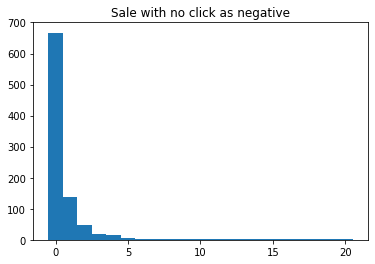

Share of sales that are taken into account in the trainset :  0.28349626221966645


In [12]:
cum_rewards.observe(data)
cum = cum_rewards.features()
# cum.to_csv("data/data_clicked2.csv")
trainset = cum

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))

#### Save info about reward provider

In [7]:
# def info_reward_provider(data,reward_provider, name, share_sales=True):
#     dict_info = {'Name':name,
#                 'Total length data':len(data),
#                  'Total length trainset':len(reward_provider.features())}
#     if share_sales==True :
#         dict_info['Share of sales in trainset'] = np.sum(reward_provider.features()["y"])/np.sum(data["z"]=="sale")
#     return dict_info

## Build features

In [8]:
from recogym.agents.sale_agent import CountViewsClicksFeatureProvider, CountViewsFeatureProvider
vc_feature = CountViewsClicksFeatureProvider(env.config)
v_feature = CountViewsFeatureProvider(env.config)

## Build train data based on features and shaped rewards

In [9]:
from recogym.agents.sale_agent import build_train_data

# train_st = build_train_data(data, vc_feature, st_rewards)
# train_cum = build_train_data(data, vc_feature, cum_rewards)

# # Short term
# pkl.dump(train_st,open("data/train_st.pkl","wb"))
# user_states, actions, rewards, proba_actions = pkl.load(open("data/train_st.pkl","rb"))

# # Cumulative
# pkl.dump(train_cum,open("data/train_cum.pkl","wb"))
# user_states, actions, rewards, proba_actions = pkl.load(open("data/train_cum.pkl","rb"))

## Train agent

In [11]:
from recogym.agents.sale_agent import SaleLikelihoodAgent, SaleProductLikelihoodAgent

from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))

from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args,
                                                                    **env_1_sale_args,
                                                                    'select_randomly': True}))

from recogym.agents.sale_oracle import ClickViewSaleOracleAgent
env.reset()
cvs_oracle = ClickViewSaleOracleAgent(env=env)
cvs_oracle.reset()

from recogym.agents.sale_oracle import ClickSaleOracleAgent
env.reset()
cs_oracle = ClickSaleOracleAgent(env=env)
cs_oracle.reset()

from recogym.agents.sale_count_oracle import ClickViewSaleCountOracleAgent
env.reset()
cvs_count_oracle = ClickViewSaleCountOracleAgent(env=env)
cvs_count_oracle.reset()

from recogym.agents.sale_count_oracle import ClickSaleCountOracleAgent
env.reset()
cs_count_oracle = ClickSaleCountOracleAgent(env=env)
cs_count_oracle.reset()

from recogym.agents.sale_oracle import ClickViewExpectSalesOracleAgent
env.reset()
cves_oracle = ClickViewExpectSalesOracleAgent(env = env)
cves_oracle.reset()

from recogym.agents.sale_oracle import ClickViewExpectGhostSalesOracleAgent
env.reset()
cvegs_oracle = ClickViewExpectGhostSalesOracleAgent(env = env)
cvegs_oracle.reset()

from recogym.agents.sale_count_oracle import ClickViewExpectSalesCountOracleAgent
env.reset()
cvesc_oracle = ClickViewExpectSalesCountOracleAgent(env = env)
cvesc_oracle.reset()

## Random logging policy

In [12]:
info = {}

likelihood_logreg_click = SaleLikelihoodAgent(v_feature, Click_rewards)
likelihood_logreg_click.train(data)
info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info

likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                discounts=[0,0])
likelihood_saleclickprod.train(data)
info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info

likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_all_pureorganic], 
                                                discounts=[0,0,-1])
likelihood_saleclickprod_discount.train(data)
info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info

# likelihood_logreg_mdp_all = SaleLikelihoodAgent(vc_feature, MDP_rewards_all)
# likelihood_logreg_mdp_all.train(data)
# info[likelihood_logreg_mdp_all.info["Name"]] = likelihood_logreg_mdp_all.info

# likelihood_logreg_cum_all = SaleLikelihoodAgent(vc_feature, cum_rewards_all)
# likelihood_logreg_cum_all.train(data)
# info[likelihood_logreg_cum_all.info["Name"]] = likelihood_logreg_cum_all.info


# likelihood_logreg_st_all = SaleLikelihoodAgent(vc_feature, st_rewards_all)
# likelihood_logreg_st_all.train(data)
# info[likelihood_logreg_st_all.info["Name"]] = likelihood_logreg_st_all.info


# likelihood_logreg_mdp = SaleLikelihoodAgent(vc_feature, MDP_rewards)
# likelihood_logreg_mdp.train(data)
# info[likelihood_logreg_mdp.info["Name"]] = likelihood_logreg_mdp.info


# likelihood_logreg_cum = SaleLikelihoodAgent(vc_feature, cum_rewards)
# likelihood_logreg_cum.train(data)
# info[likelihood_logreg_cum.info["Name"]] = likelihood_logreg_cum.info


# likelihood_logreg_st = SaleLikelihoodAgent(vc_feature, st_rewards)
# likelihood_logreg_st.train(data)
# info[likelihood_logreg_st.info["Name"]] = likelihood_logreg_st.info

In [ ]:
env.reset()
res_all_test=verify_agents_sale(
    env,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood click': likelihood_logreg_click,
        'likelihood_saleclickprod':likelihood_saleclickprod,
        'likelihood_saleclickprod_discount':likelihood_saleclickprod_discount,
#         'likelihood MDP all': likelihood_logreg_mdp_all,
#         'likelihood ST all': likelihood_logreg_st_all,
#         'likelihood cum all': likelihood_logreg_cum_all,
#         'likelihood MDP': likelihood_logreg_mdp,
#         'likelihood ST': likelihood_logreg_st,
#         'likelihood cum': likelihood_logreg_cum,
#         'cvs_oracle':cvs_oracle,
#         'cs_oracle':cs_oracle,
#         'cvs_count_oracle':cvs_count_oracle,
#         'cs_count_oracle':cs_count_oracle,
#         'cves_oracle':cves_oracle,
#         'cvegs_oracle':cvegs_oracle,
#         'cvesc_oracle':cvesc_oracle
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.59it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.45it/s]
Organic Users: 0it [00:00, ?it/s]
Users:  88%|███████████████████████████████████████████████████████████████▋        | 884/1000 [26:11<05:27,  2.82s/it]

In [ ]:
# res_all_test["sale rate"]
# res_all_test["CTR"]
# res_all_test["Tot sales"]
# res_all_test['Share user with sale']

In [ ]:
pkl.dump([res_all_test, env_1_sale_args, info,
          [likelihood_logreg_click,likelihood_saleclickprod,likelihood_saleclickprod_discount]],
         open("data/res_all_test3.pkl","wb"))

In [ ]:
res = res_all_test
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

## Popularity agent as logging policy

In [ ]:
from recogym.envs.utils_sale import PopularityAgent
popagent=PopularityAgent(Configuration({**env_1_sale_args,'num_products': num_products}))
popagent.logging_pretrain(data)

# num_users = 1000
num_users = 5000
data = deepcopy(env).generate_logs(num_users, agent=popagent)
pkl.dump(data,open(str('data\data'+str(num_users)+'pop.pkl'),'wb'))
data = pkl.load(open(str('data\data'+str(num_users)+'pop.pkl'),'rb'))

In [ ]:
info = {}

likelihood_logreg_click = SaleLikelihoodAgent(v_feature, Click_rewards)
likelihood_logreg_click.train(data)
info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info

likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                discounts=[0,0])
likelihood_saleclickprod.train(data)
info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info

likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_all_pureorganic], 
                                                discounts=[0,0,-1])
likelihood_saleclickprod_discount.train(data)
info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info

# likelihood_logreg_mdp_all = SaleLikelihoodAgent(vc_feature, MDP_rewards_all)
# likelihood_logreg_mdp_all.train(data)
# info[likelihood_logreg_mdp_all.info["Name"]] = likelihood_logreg_mdp_all.info

# likelihood_logreg_cum_all = SaleLikelihoodAgent(vc_feature, cum_rewards_all)
# likelihood_logreg_cum_all.train(data)
# info[likelihood_logreg_cum_all.info["Name"]] = likelihood_logreg_cum_all.info


# likelihood_logreg_st_all = SaleLikelihoodAgent(vc_feature, st_rewards_all)
# likelihood_logreg_st_all.train(data)
# info[likelihood_logreg_st_all.info["Name"]] = likelihood_logreg_st_all.info


# likelihood_logreg_mdp = SaleLikelihoodAgent(vc_feature, MDP_rewards)
# likelihood_logreg_mdp.train(data)
# info[likelihood_logreg_mdp.info["Name"]] = likelihood_logreg_mdp.info


# likelihood_logreg_cum = SaleLikelihoodAgent(vc_feature, cum_rewards)
# likelihood_logreg_cum.train(data)
# info[likelihood_logreg_cum.info["Name"]] = likelihood_logreg_cum.info


# likelihood_logreg_st = SaleLikelihoodAgent(vc_feature, st_rewards)
# likelihood_logreg_st.train(data)
# info[likelihood_logreg_st.info["Name"]] = likelihood_logreg_st.info

In [ ]:
env.reset()
res_all_test_pop=verify_agents_sale(
    env,
#     number_of_users=100,
#     number_of_users=500,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood click': likelihood_logreg_click,
        'likelihood_saleclickprod':likelihood_saleclickprod,
        'likelihood_saleclickprod_discount':likelihood_saleclickprod_discount,
#         'likelihood MDP all': likelihood_logreg_mdp_all,
#         'likelihood ST all': likelihood_logreg_st_all,
#         'likelihood cum all': likelihood_logreg_cum_all,
#         'likelihood MDP': likelihood_logreg_mdp,
#         'likelihood ST': likelihood_logreg_st,
#         'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

In [ ]:
pkl.dump([res_all_test_pop, env_1_sale_args, info,
          [likelihood_logreg_click,likelihood_saleclickprod,likelihood_saleclickprod_discount]],
         open("data/res_all_test_pop2.pkl","wb"))

In [ ]:
res = res_all_test_pop
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

### Organic user counter as logging policy

In [ ]:
# num_users = 1000
num_users = 5000
data = deepcopy(env).generate_logs(num_users, agent=organic_counter_agent)
pkl.dump(data,open(str('data\data'+str(num_users)+'organic.pkl'),'wb'))
data = pkl.load(open(str('data\data'+str(num_users)+'organic.pkl'),'rb'))

In [ ]:
info = {}

likelihood_logreg_click = SaleLikelihoodAgent(v_feature, Click_rewards)
likelihood_logreg_click.train(data)
info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info

likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                discounts=[0,0])
likelihood_saleclickprod.train(data)
info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info

likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_all_pureorganic], 
                                                discounts=[0,0,-1])
likelihood_saleclickprod_discount.train(data)
info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info

# likelihood_logreg_mdp_all = SaleLikelihoodAgent(vc_feature, MDP_rewards_all)
# likelihood_logreg_mdp_all.train(data)
# info[likelihood_logreg_mdp_all.info["Name"]] = likelihood_logreg_mdp_all.info

# likelihood_logreg_cum_all = SaleLikelihoodAgent(vc_feature, cum_rewards_all)
# likelihood_logreg_cum_all.train(data)
# info[likelihood_logreg_cum_all.info["Name"]] = likelihood_logreg_cum_all.info


# likelihood_logreg_st_all = SaleLikelihoodAgent(vc_feature, st_rewards_all)
# likelihood_logreg_st_all.train(data)
# info[likelihood_logreg_st_all.info["Name"]] = likelihood_logreg_st_all.info


# likelihood_logreg_mdp = SaleLikelihoodAgent(vc_feature, MDP_rewards)
# likelihood_logreg_mdp.train(data)
# info[likelihood_logreg_mdp.info["Name"]] = likelihood_logreg_mdp.info


# likelihood_logreg_cum = SaleLikelihoodAgent(vc_feature, cum_rewards)
# likelihood_logreg_cum.train(data)
# info[likelihood_logreg_cum.info["Name"]] = likelihood_logreg_cum.info


# likelihood_logreg_st = SaleLikelihoodAgent(vc_feature, st_rewards)
# likelihood_logreg_st.train(data)
# info[likelihood_logreg_st.info["Name"]] = likelihood_logreg_st.info

In [ ]:
env.reset()
res_all_test_organic=verify_agents_sale(
    env,
#     number_of_users=100,
#     number_of_users=500,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood click': likelihood_logreg_click,
        'likelihood_saleclickprod':likelihood_saleclickprod,
        'likelihood_saleclickprod_discount':likelihood_saleclickprod_discount,
#         'likelihood MDP all': likelihood_logreg_mdp_all,
#         'likelihood ST all': likelihood_logreg_st_all,
#         'likelihood cum all': likelihood_logreg_cum_all,
#         'likelihood MDP': likelihood_logreg_mdp,
#         'likelihood ST': likelihood_logreg_st,
#         'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

In [ ]:
pkl.dump([res_all_test_organic, env_1_sale_args, info,
          [likelihood_logreg_click,likelihood_saleclickprod,likelihood_saleclickprod_discount]],
         open("data/res_all_test_organic2.pkl","wb"))

In [ ]:
res = res_all_test_organic
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

## Likelihood clicks as logging policy

In [ ]:
num_users = 5000
data = deepcopy(env).generate_logs(num_users, agent=likelihood_logreg_click)
pkl.dump(data,open(str('data\data'+str(num_users)+'like_click.pkl'),'wb'))
data = pkl.load(open(str('data\data'+str(num_users)+'like_click.pkl'),'rb'))

In [ ]:
info = {}

likelihood_logreg_click = SaleLikelihoodAgent(v_feature, Click_rewards)
likelihood_logreg_click.train(data)
info[likelihood_logreg_click.info["Name"]] = likelihood_logreg_click.info

likelihood_saleclickprod = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all], 
                                                discounts=[0,0])
likelihood_saleclickprod.train(data)
info[likelihood_saleclickprod.info["Name"]] = likelihood_saleclickprod.info

likelihood_saleclickprod_discount = SaleProductLikelihoodAgent(feature_provider_list=[v_feature,v_feature,v_feature], 
                                                reward_provider_list=[Click_rewards,MDP_rewards_all,MDP_rewards_all_pureorganic], 
                                                discounts=[0,0,-1])
likelihood_saleclickprod_discount.train(data)
info[likelihood_saleclickprod_discount.info["Name"]] = likelihood_saleclickprod_discount.info

# likelihood_logreg_mdp_all = SaleLikelihoodAgent(vc_feature, MDP_rewards_all)
# likelihood_logreg_mdp_all.train(data)
# info[likelihood_logreg_mdp_all.info["Name"]] = likelihood_logreg_mdp_all.info

# likelihood_logreg_cum_all = SaleLikelihoodAgent(vc_feature, cum_rewards_all)
# likelihood_logreg_cum_all.train(data)
# info[likelihood_logreg_cum_all.info["Name"]] = likelihood_logreg_cum_all.info


# likelihood_logreg_st_all = SaleLikelihoodAgent(vc_feature, st_rewards_all)
# likelihood_logreg_st_all.train(data)
# info[likelihood_logreg_st_all.info["Name"]] = likelihood_logreg_st_all.info


# likelihood_logreg_mdp = SaleLikelihoodAgent(vc_feature, MDP_rewards)
# likelihood_logreg_mdp.train(data)
# info[likelihood_logreg_mdp.info["Name"]] = likelihood_logreg_mdp.info


# likelihood_logreg_cum = SaleLikelihoodAgent(vc_feature, cum_rewards)
# likelihood_logreg_cum.train(data)
# info[likelihood_logreg_cum.info["Name"]] = likelihood_logreg_cum.info


# likelihood_logreg_st = SaleLikelihoodAgent(vc_feature, st_rewards)
# likelihood_logreg_st.train(data)
# info[likelihood_logreg_st.info["Name"]] = likelihood_logreg_st.info

In [ ]:
env.reset()
res_all_test_click=verify_agents_sale(
    env,
#     number_of_users=100,
#     number_of_users=500,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood click': likelihood_logreg_click,
        'likelihood_saleclickprod':likelihood_saleclickprod,
        'likelihood_saleclickprod_discount':likelihood_saleclickprod_discount,
#         'likelihood MDP all': likelihood_logreg_mdp_all,
#         'likelihood ST all': likelihood_logreg_st_all,
#         'likelihood cum all': likelihood_logreg_cum_all,
#         'likelihood MDP': likelihood_logreg_mdp,
#         'likelihood ST': likelihood_logreg_st,
#         'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

In [ ]:
pkl.dump([res_all_test_click, env_1_sale_args, info,
          [likelihood_logreg_click,likelihood_saleclickprod,likelihood_saleclickprod_discount]],
         open("data/res_all_test_click2.pkl","wb"))

In [ ]:
res = res_all_test_click
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
env.reset()
res_all_test_click2=verify_agents_sale(
    env,
#     number_of_users=100,
#     number_of_users=500,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood click': likelihood_logreg_click,
        'likelihood_saleclickprod':likelihood_saleclickprod,
        'likelihood_saleclickprod_discount':likelihood_saleclickprod_discount,
#         'likelihood MDP all': likelihood_logreg_mdp_all,
#         'likelihood ST all': likelihood_logreg_st_all,
#         'likelihood cum all': likelihood_logreg_cum_all,
#         'likelihood MDP': likelihood_logreg_mdp,
#         'likelihood ST': likelihood_logreg_st,
#         'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

In [ ]:
pkl.dump([res_all_test_click2, env_1_sale_args, info],open("data/res_all_test_click3.pkl","wb"))

In [ ]:
res = res_all_test_click2
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None